<a href="https://colab.research.google.com/github/kaushik701/Classify-Space-Signals-Using-Keras/blob/main/Space_Signal_Classification_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install livelossplot
!pip install tensorflow
!pip install keras

1.**IMPORTING THE NECESSARY LIBRARIES**

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, LSTM, Reshape
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.simplefilter('ignore')
np.random.seed(42)

2.**DATA LOADING AND DATA PREPROCESSING**

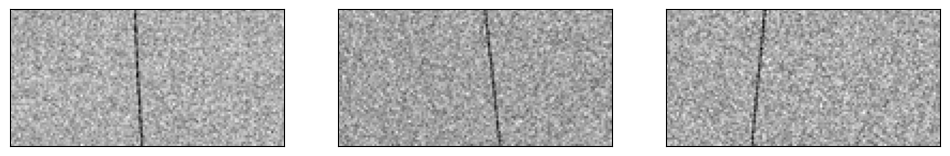

In [4]:
# Load data
train_images = pd.read_csv('/content/dataset/train/images.csv', header=None)
train_labels = pd.read_csv('/content/dataset/train/labels.csv', header=None)
val_images = pd.read_csv('/content/dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('/content/dataset/validation/labels.csv', header=None)

# Reshape data
X_train = train_images.values.reshape(3200, 64, 128, 1)
X_val = val_images.values.reshape(800, 64, 128, 1)
y_train = train_labels.values
y_val = val_labels.values

# Data visualization
plt.figure(0, figsize=(12, 12))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    img = np.squeeze(X_train[np.random.randint(0, X_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


3.**DATA AUGMENTATION**

In [7]:
datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen_val = ImageDataGenerator(
    horizontal_flip=True
)

datagen_train.fit(X_train)
datagen_val.fit(X_val)

4.**MODEL ARCHITECTURE**

In [12]:
def build_enhanced_model(input_shape=(64, 128, 1)):
    # Input layer
    inputs = Input(shape=input_shape)

    # First Stream - CNN
    x1 = Conv2D(64, (3,3), padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation('elu')(x1)
    x1 = MaxPooling2D(pool_size=(2,2))(x1)  # Output: (32, 64, 64)

    x1 = Conv2D(128, (3,3), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('elu')(x1)
    x1 = MaxPooling2D(pool_size=(2,2))(x1)  # Output: (16, 32, 128)

    # Second Stream - Residual Network
    x2 = Conv2D(64, (3,3), padding='same')(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation('elu')(x2)
    # Match dimensions with x1
    x2 = MaxPooling2D(pool_size=(2,2))(x2)  # Output: (32, 64, 64)
    x2 = Conv2D(128, (3,3), padding='same')(x2)
    x2 = MaxPooling2D(pool_size=(2,2))(x2)  # Output: (16, 32, 128)

    # Combine streams
    x = tf.keras.layers.Add()([x1, x2])  # Now both have shape (16, 32, 128)

    # Additional processing
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)  # Output: (8, 16, 256)
    x = Dropout(0.3)(x)

    # Flatten before dense layers
    x = Flatten()(x)

    # Dense layers
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

5.**TRAINING CONFIGURATION**

In [13]:
# Focal Loss implementation
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_mean((1-alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    decay_steps,
    t_mul=2.0,
    m_mul=0.9
)

# Create and compile model
model = build_enhanced_model()
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 128, 64)    │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64, 128, 64)    │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 64, 128, 64)    │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 128, 64)    │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 64, 64)     │              0 │ activation_7[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 128, 64)    │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 64, 128, 64)    │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 64, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 64, 64)     │              0 │ activation_9[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 32, 64, 128)    │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 32, 128)    │              0 │ activation_8[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 32, 128)    │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 17,228,036 (65.72 MB)

 Trainable params: 17,225,988 (65.71 MB)

 Non-trainable params: 2,048 (8.00 KB)

6.**MODEL TRAINING**

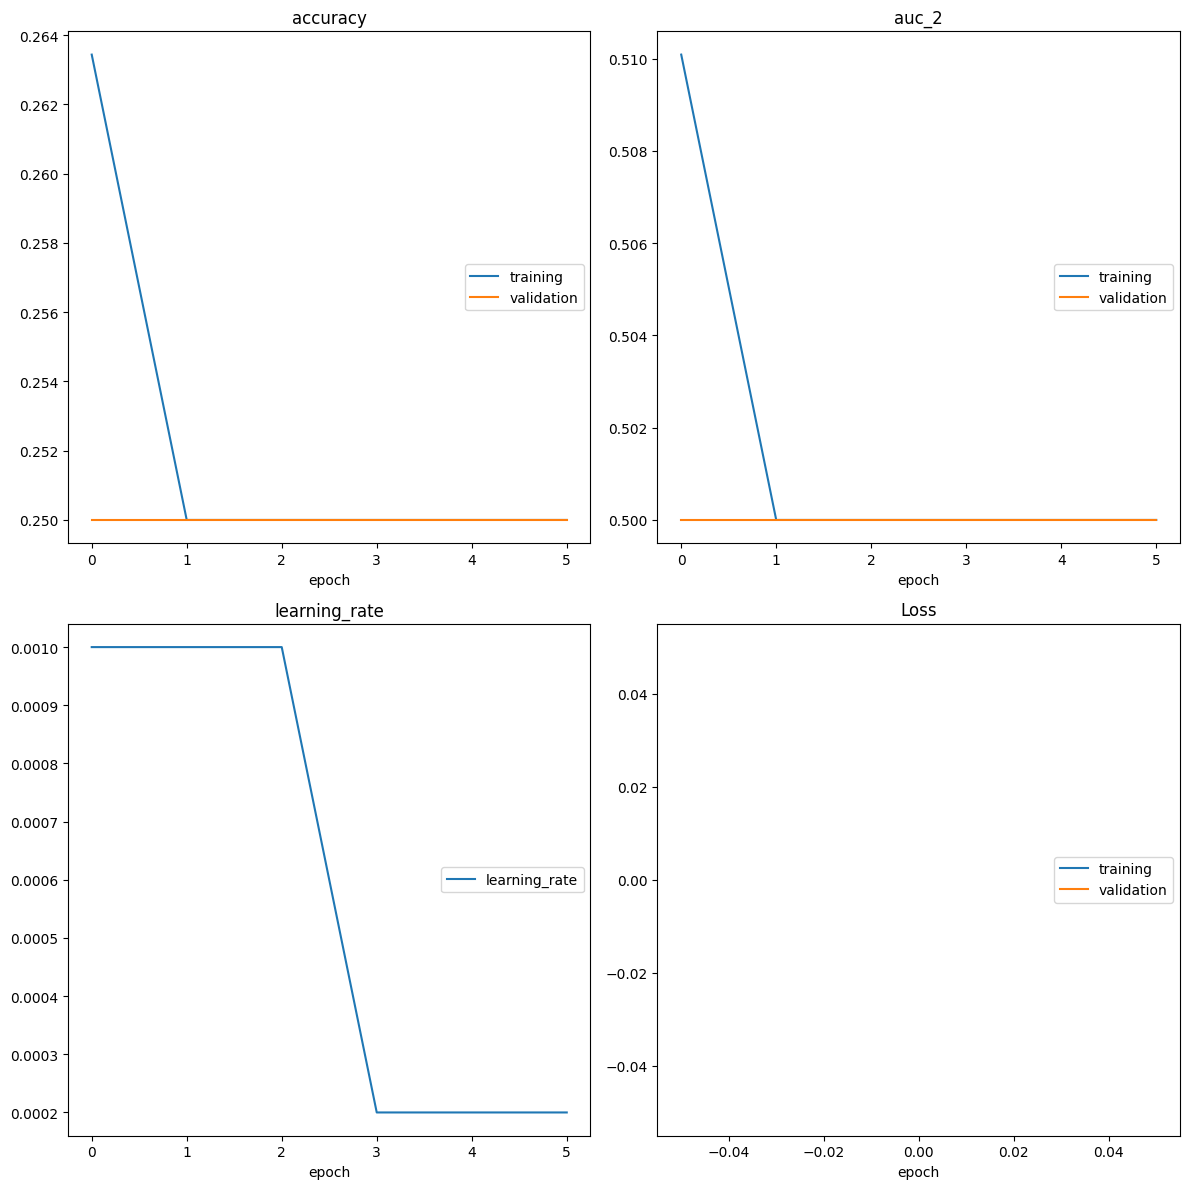

accuracy
	training         	 (min:    0.250, max:    0.263, cur:    0.250)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
auc_2
	training         	 (min:    0.500, max:    0.510, cur:    0.500)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2558 - auc_2: 0.5000 - loss: nan - val_accuracy: 0.2500 - val_auc_2: 0.5000 - val_loss: nan - learning_rate: 2.0000e-04


In [16]:
# 1. First, let's simplify the learning rate approach
initial_learning_rate = 0.001

# 2. Create and compile model with simplified optimizer
model = build_enhanced_model()
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# 3. Modified callbacks with learning rate reduction
callbacks = [
    ModelCheckpoint(
        "best_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    PlotLossesCallback()
]

# 4. Training
batch_size = 32
history = model.fit(
    datagen_train.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps=len(X_val)//batch_size,
    epochs=50,
    callbacks=callbacks
)

7.**EVALUATION AND VISUALIZATION**

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1291 - auc_2: 0.5000 - loss: nan
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200

    accuracy                           0.25       800
   macro avg       0.06      0.25      0.10       800
weighted avg       0.06      0.25      0.10       800



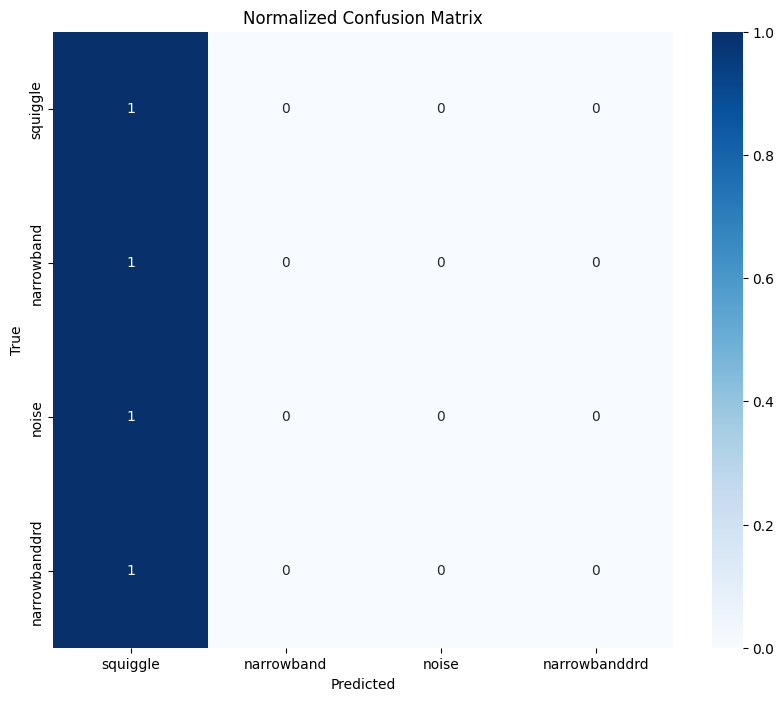

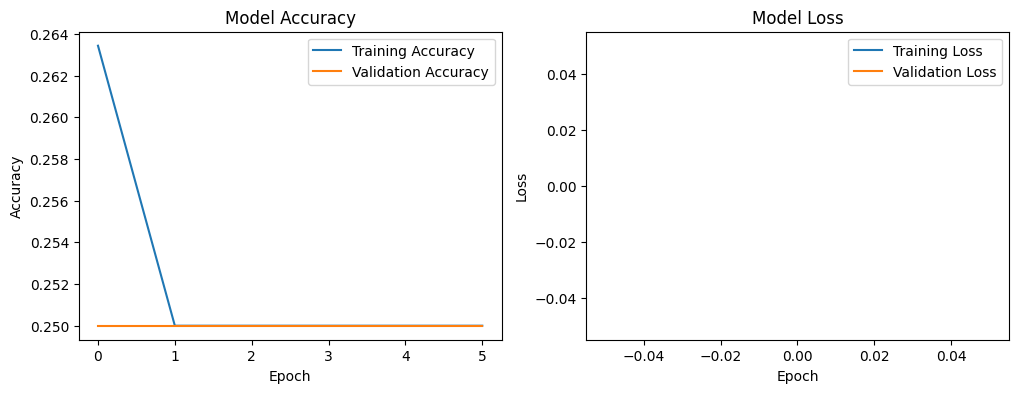

In [17]:
# Model evaluation
model.evaluate(X_val, y_val)

# Predictions
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Training history visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8.**GENERATE TEST DATA FUNCTION**

In [18]:
def generate_test_signals(num_samples=100):
    """
    Generate synthetic test signals similar to your training data
    """
    test_signals = []
    for _ in range(num_samples):
        # Generate random signal type (0: squiggle, 1: narrowband, 2: noise, 3: narrowbanddrd)
        signal_type = np.random.randint(0, 4)

        # Create empty signal
        signal = np.zeros((64, 128))

        if signal_type == 0:  # Squiggle
            for i in range(64):
                freq = np.sin(i/10) * 20 + 64
                signal[i, int(freq):int(freq)+1] = 1

        elif signal_type == 1:  # Narrowband
            freq = np.random.randint(30, 98)
            signal[:, freq:freq+2] = 1

        elif signal_type == 2:  # Noise
            signal = np.random.random((64, 128)) * 0.3

        else:  # Narrowbanddrd
            freq = np.random.randint(30, 98)
            drift = np.random.randint(-10, 10)
            for i in range(64):
                current_freq = freq + (drift * i / 64)
                signal[i, int(current_freq):int(current_freq)+2] = 1

        test_signals.append(signal)

    return np.array(test_signals)

9.**TEST MODEL FUNCTION**

In [19]:
def test_model(model, test_data, show_examples=True):
    """
    Test the model and visualize results
    """
    # Reshape test data to match model input
    test_data = test_data.reshape(-1, 64, 128, 1)

    # Get predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)

    # Class labels
    class_labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

    # Visualize some examples
    if show_examples:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        for i, ax in enumerate(axes.flat):
            if i < len(test_data):
                ax.imshow(np.squeeze(test_data[i]), cmap='gray')
                ax.set_title(f'Predicted: {class_labels[predicted_classes[i]]}')
                ax.axis('off')
        plt.tight_layout()
        plt.show()

    return predictions, predicted_classes

10.**COMPLETE TESTING PIPELINE**

In [20]:
# Generate and test synthetic data
def run_model_test(model_path=None):
    """
    Complete testing pipeline
    """
    # Load the trained model if path is provided
    if model_path:
        model = tf.keras.models.load_model(model_path,
                                         custom_objects={'focal_loss_fixed': focal_loss()})

    # Generate test data
    print("Generating test signals...")
    test_signals = generate_test_signals(num_samples=100)

    # Test the model
    print("\nTesting model...")
    predictions, predicted_classes = test_model(model, test_signals)

    # Print distribution of predictions
    unique, counts = np.unique(predicted_classes, return_counts=True)
    print("\nPrediction distribution:")
    class_labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
    for u, c in zip(unique, counts):
        print(f"{class_labels[u]}: {c} samples")

    # Confidence analysis
    confidence_scores = np.max(predictions, axis=1)
    print("\nConfidence analysis:")
    print(f"Mean confidence: {np.mean(confidence_scores):.3f}")
    print(f"Min confidence: {np.min(confidence_scores):.3f}")
    print(f"Max confidence: {np.max(confidence_scores):.3f}")

    # Visualize confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=20)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.show()

    return predictions, predicted_classes, test_signals

11.**USAGE EXAMPLES**

Running basic test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


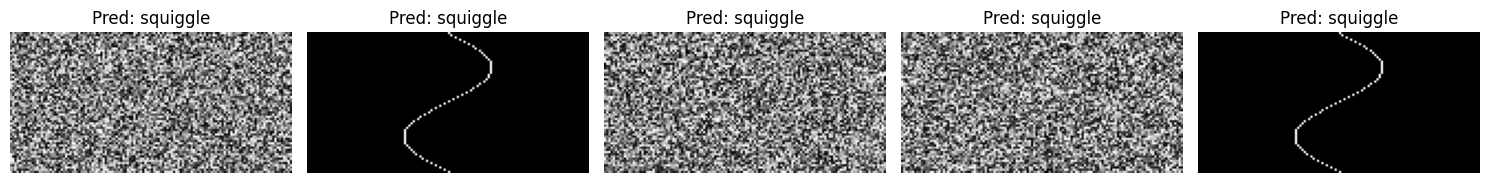


Running full test...
Using current model as loading saved model failed
Generating test signals...

Testing model...
Error during testing: cannot access local variable 'model' where it is not associated with a value


In [22]:
def run_model_test(model_path=None):
    """
    Complete testing pipeline with error handling
    """
    try:
        # Load the trained model if path is provided
        if model_path:
            try:
                model = tf.keras.models.load_model(model_path)
            except:
                print("Using current model as loading saved model failed")

        # Generate test data
        print("Generating test signals...")
        test_signals = generate_test_signals(num_samples=100)

        # Ensure test data is properly scaled
        test_signals = test_signals.astype('float32')
        test_signals = (test_signals - np.mean(test_signals)) / np.std(test_signals)

        # Reshape and prepare test data
        test_data = test_signals.reshape(-1, 64, 128, 1)

        # Test the model
        print("\nTesting model...")
        predictions = model.predict(test_data)

        # Check for NaN values
        if np.isnan(predictions).any():
            print("Warning: NaN values detected in predictions")
            predictions = np.nan_to_num(predictions)

        predicted_classes = np.argmax(predictions, axis=1)

        # Print distribution of predictions
        unique, counts = np.unique(predicted_classes, return_counts=True)
        print("\nPrediction distribution:")
        class_labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
        for u, c in zip(unique, counts):
            print(f"{class_labels[u]}: {c} samples")

        # Confidence analysis
        confidence_scores = np.max(predictions, axis=1)
        valid_scores = confidence_scores[~np.isnan(confidence_scores)]

        if len(valid_scores) > 0:
            print("\nConfidence analysis:")
            print(f"Mean confidence: {np.mean(valid_scores):.3f}")
            print(f"Min confidence: {np.min(valid_scores):.3f}")
            print(f"Max confidence: {np.max(valid_scores):.3f}")

            # Visualize confidence distribution
            plt.figure(figsize=(10, 6))
            plt.hist(valid_scores, bins=20, range=(0, 1))
            plt.title('Distribution of Prediction Confidence')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.show()
        else:
            print("No valid confidence scores to analyze")

        return predictions, predicted_classes, test_signals

    except Exception as e:
        print(f"Error during testing: {str(e)}")
        return None, None, None

# Modified test function with basic visualization
def basic_test(model, num_samples=5):
    """
    Basic test function with minimal visualization
    """
    # Generate and prepare test data
    test_signals = generate_test_signals(num_samples)
    test_data = test_signals.reshape(-1, 64, 128, 1)

    # Get predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)

    # Visualize results
    class_labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np.squeeze(test_data[i]), cmap='gray')
        plt.title(f'Pred: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predictions, predicted_classes, test_signals

# Try the basic test first
print("Running basic test...")
basic_predictions, basic_classes, basic_signals = basic_test(model, num_samples=5)

# If basic test works, try the full test
if basic_predictions is not None:
    print("\nRunning full test...")
    predictions, predicted_classes, test_signals = run_model_test("best_model.h5")

Verifying model and data...
Test data shape: (1, 64, 128, 1)
Test data statistics:
Mean: 0.016
Std: 0.124
Min: 0.000
Max: 1.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Prediction shape: (1, 4)
Prediction sample: [nan nan nan nan]

Verification successful, proceeding with tests...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


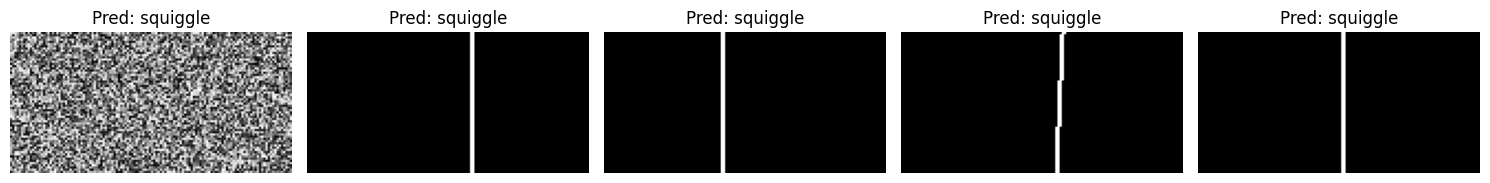

In [26]:
def verify_model_and_data():
    """
    Verify model and data integrity
    """
    # Generate a single test sample
    test_signal = generate_test_signals(1)
    test_data = test_signal.reshape(1, 64, 128, 1)

    # Print shapes and basic statistics
    print("Test data shape:", test_data.shape)
    print("Test data statistics:")
    print(f"Mean: {np.mean(test_data):.3f}")
    print(f"Std: {np.std(test_data):.3f}")
    print(f"Min: {np.min(test_data):.3f}")
    print(f"Max: {np.max(test_data):.3f}")

    # Try a single prediction
    try:
        pred = model.predict(test_data)
        print("\nPrediction shape:", pred.shape)
        print("Prediction sample:", pred[0])
        return True
    except Exception as e:
        print(f"\nError during prediction: {str(e)}")
        return False

# Run verification before testing
print("Verifying model and data...")
if verify_model_and_data():
    print("\nVerification successful, proceeding with tests...")
    basic_predictions, basic_classes, basic_signals = basic_test(model, num_samples=5)
else:
    print("\nVerification failed, please check model and data")